In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 
import json

In [2]:
from limit.writeABCD import loadhist

In [3]:
dphi_lepcuts = np.linspace(0,np.pi,31)[1:-2]
cut = {"CSC":(200,dphi_lepcuts[-4],None), "DT":(130,dphi_lepcuts[-4],None)}
data = loadhist('../HNL_histograms_Feb23_muons_signal.pickle',True,cut,False)
data_new = loadhist('../HNL_histograms_Mar1_muons_signal.pickle',True,cut,False)

In [4]:
data_all = {**data, **data_new}
arr_src = data["HNL_muonType_mHNL2p0_pl1000"]
arr_new = data["HNL_muonType_mHNL4p0_pl2000"]

In [7]:
from HNLprocessor.util import f_1m

def f_xsec(m):
    def xsec_m(x):
        return f_1m(m)/(x/1000.)
    return xsec_m


# Find the corresponding yield of (m,ct)-> (m,xx)
def shift_ctau(N_yield,m_old,ct_old,m_new):
    ct_new = (m_new/m_old) * ct_old
    return N_yield * f_xsec(m_new)(ct_new)/f_xsec(m_old)(ct_old)

In [8]:
print("source (2,1000) -> ct_new = (4,2000)")
print("shifted Yield at 4 (ct,yield)= ",shift_ctau(arr_src["CSC"],2,1000,4))
print("shifted Yield at 4 (ct,yield)= ",shift_ctau(arr_src["CSC_unc"],2,1000,4))
print("Gen Yield at 4 (ct,yield)   = ",arr_new["CSC"])
print("Gen Yield at 4 (ct,yield)   = ",arr_new["CSC_unc"])

source (2,1000) -> ct_new = (4,2000)
shifted Yield at 4 (ct,yield)=  [0.11948856 0.43452645 1.24169806 0.3846727 ]
shifted Yield at 4 (ct,yield)=  [0.04850425 0.10908603 0.16171155 0.09619329]
Gen Yield at 4 (ct,yield)   =  [0.13519757 0.31802791 1.2621166  0.54970721]
Gen Yield at 4 (ct,yield)   =  [0.01302777 0.02097876 0.04041055 0.02615742]


In [9]:
def sortzip(x,y,z):
    x_new=np.array(sorted(zip(x,y,z)))[:,0]
    y_new=np.array(sorted(zip(x,y,z)))[:,1]
    z_new=np.array(sorted(zip(x,y,z)))[:,2]
    return x_new,y_new,z_new

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

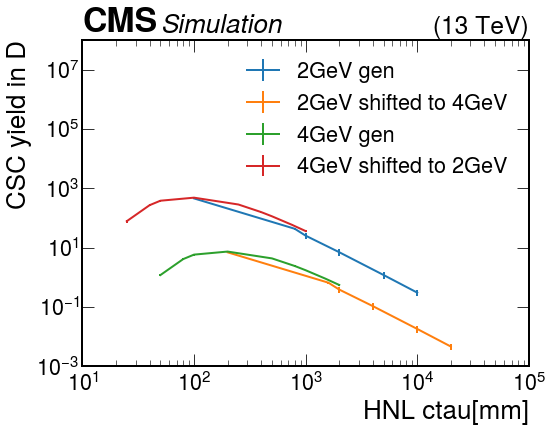

In [10]:
plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))

x = np.array([float(k.split("_")[-1].replace("pl","")) for k,v in data.items() if "mHNL2p0" in k])
y = np.array([v['CSC'][-1] for k,v in data.items() if "mHNL2p0" in k])
z = np.array([v['CSC_unc'][-1] for k,v in data.items() if "mHNL2p0" in k])
ctau,D_2GeV_CSC,D_2GeV_CSC_unc = sortzip(x[1:],y[1:],z[1:])

x =np.array([float(k.split("_")[-1].replace("pl","")) for k,v in data.items() if "mHNL4p0" in k])
y = np.array([v['CSC'][-1] for k,v in data.items() if "mHNL4p0" in k])
z = np.array([v['CSC_unc'][-1] for k,v in data.items() if "mHNL4p0" in k])
ctau_4,D_4GeV_CSC,D_4GeV_CSC_unc = sortzip(x,y,z)

ax.errorbar(ctau,D_2GeV_CSC,D_2GeV_CSC_unc,lw=2,label="2GeV gen")
ax.errorbar(ctau*2,shift_ctau(D_2GeV_CSC,2,ctau,4),shift_ctau(D_2GeV_CSC_unc,2,ctau,4),
            lw=2,label="2GeV shifted to 4GeV")
ax.errorbar(ctau_4,D_4GeV_CSC,D_4GeV_CSC_unc,lw=2,label="4GeV gen")
ax.errorbar(ctau_4*0.5,shift_ctau(D_4GeV_CSC,4,ctau_4,2),shift_ctau(D_4GeV_CSC_unc,4,ctau_4,2)
            ,lw=2,label="4GeV shifted to 2GeV")
ax.set_ylim(1e-3,1e8)
ax.set_yscale("log")
ax.set_xlim(10,1e5)
ax.set_xscale("log")
ax.set_xlabel("HNL ctau[mm]")
ax.set_ylabel("CSC yield in D")
ax.legend()
hep.cms.label(ax=ax)

In [12]:

import json 
f_yield = "../limit/combine/HNL_datacards/ele_v6/yields.json"
shifts = [
    {"m_src":4.0,"m_target":3.0,"names":[],"CSC_target":[],"DT_target":[]}
]

with open(f_yield,'r') as f:
    data = json.load(f)
    for name,signal in data.items():
        if name=="bkg": continue
        m =float(name.split("_")[-2].replace("mHNL","").replace("p","."))
        ct =float(name.split("_")[-1].replace("pl",""))    
        for shift in shifts:
            if m==shift["m_src"]:     
                ct_new = (shift['m_target']/m) * ct            
                shift["CSC_target"].append(shift_ctau(np.array(signal['CSC']),m,ct,shift['m_target']))            
                shift["DT_target"].append(shift_ctau(np.array(signal['DT']),m,ct,shift['m_target']))                        
                m_src = str(shift["m_src"]).replace(".","p")
                m_tar = str(shift["m_target"]).replace(".","p") 
                ct_src = name.split("_")[-1]
                ct_tar = "pl"+str(int(ct_new))
                shift["names"].append(name.replace(m_src,m_tar).replace(ct_src,ct_tar))
for shift in shifts:
    if len(shift['names'])>0:
        for i,name in enumerate(shift['names']):
            data[name]={
                "CSC":shift["CSC_target"][i].tolist(),
                "DT":shift["CSC_target"][i].tolist(),  
                "norm":1,
            }  
    else:
        print("Cannot find source data of mass = ",shift['m_src'])

# with open(f_yield,'w') as f:
#     f.write(json.dumps(data,indent=4))    
    